# Calcul des statistiques

Dans ce notebook nous calculons les différents résultats que nous expliquons dans notre [rapport](rapport.md).

In [1]:
from agrovoc import Agrovoc
from rdflib import Graph

On commence par créer une instance de `Agrovoc` pour pouvoir faire des recherches de concepts.

In [2]:
# takes about 20 minutes to run

g = Graph()
agrovoc = Agrovoc(g)

Now loading the dictionary...


  0%|          | 28/36938 [00:00<04:54, 125.46it/s]

Now indexing the dictionary...


100%|██████████| 36938/36938 [04:07<00:00, 149.22it/s]


In [3]:
agrovoc.find_with_agrovoc('Cameroun')

{('http://aims.fao.org/aos/agrovoc/c_1229', 'Cameroun')}

On commence par definir une classe qui va accumuler les résultats.

In [4]:
class GrobidCallback:
    def __init__(self, agrovoc, message=""):
        self.average_accuracy = 0
        self.average_precision = 0
        self.average_recovery = 0
        self.average_nb_entities = 0
        self.message = message
        self.examples = 0
        self.memory = []
        self.text = ""
        self.agrovoc = agrovoc

    def update(self, descripteurs, concepts):
        set2 = to_agrovoc(concepts, self.agrovoc)
        self.text += ' '.join([word.replace(' ', '_') for _, word in set2])
        recovery = len(set2) / len(concepts) if len(concepts) > 0 else 0
        res = intersection(descripteurs, set2)
        accuracy = len(res) / len(descripteurs) if len(descripteurs) > 0 else 0
        precision = len(res) / len(set2) if len(set2) > 0 else 0
        self.memory.append([accuracy, precision, recovery])
        self.average_accuracy = (self.average_accuracy * self.examples + accuracy) / (self.examples + 1)
        self.average_nb_entities = (self.average_nb_entities * self.examples + len(concepts)) / (self.examples + 1)
        self.average_precision = (self.average_precision * self.examples + precision) / (self.examples + 1)
        self.average_recovery = (self.average_recovery * self.examples + recovery) / (self.examples + 1)
        self.examples += 1
        return "{} : {} , {} , {}".format(self.message, accuracy, precision, recovery)

Puis on itere a travers les publications.

In [7]:
import importlib
import grobid_utils
importlib.reload(grobid_utils)
from grobid_utils import *

In [ ]:
file = pd.read_excel('2020_export_Projet_Indexation_Automatique_Notice_accesTI_public_depuis2010_20200204.xlsx')
file = file.loc[file.LANGUE_DOC=="fre"]

cagro = GrobidCallback(agrovoc, "Agrovoc")

for i, row in file.iterrows():
    pdf = row['ACCES_TEXTE_INTEGRAL']
    descriptors = row["DESCRIPTEURS"]
    if type(descriptors) == str:
        descriptors = list(map(lambda x: x.strip(), row["DESCRIPTEURS"].split(";")))
    else:
        print('Skipped ', i)
        continue
    metadata = to_agrovoc(descriptors, agrovoc)
    xml = pdf_to_xml(pdf)
    try:
        text_json = extract_entities(xml)
        ent_and_cat = fetch_entities(text_json)    
    except Exception as e:
        print('Failed to process ', i, pdf)
        print(e)
        continue
    print(cagro.update(metadata, ent_and_cat))
  
    if cagro.examples > 200:
        break
        
print(cagro.average_accuracy, cagro.average_precsision, cagro.average_recovery, cagro.average_nb_entities)

In [54]:
print(cagro.average_accuracy, cagro.average_precsision, cagro.average_recovery, cagro.average_nb_entities)
print(len(cagro.memory))

0.4401505415544472 0.08381333188496261 0.24366609791698723 283.96153846153857
130


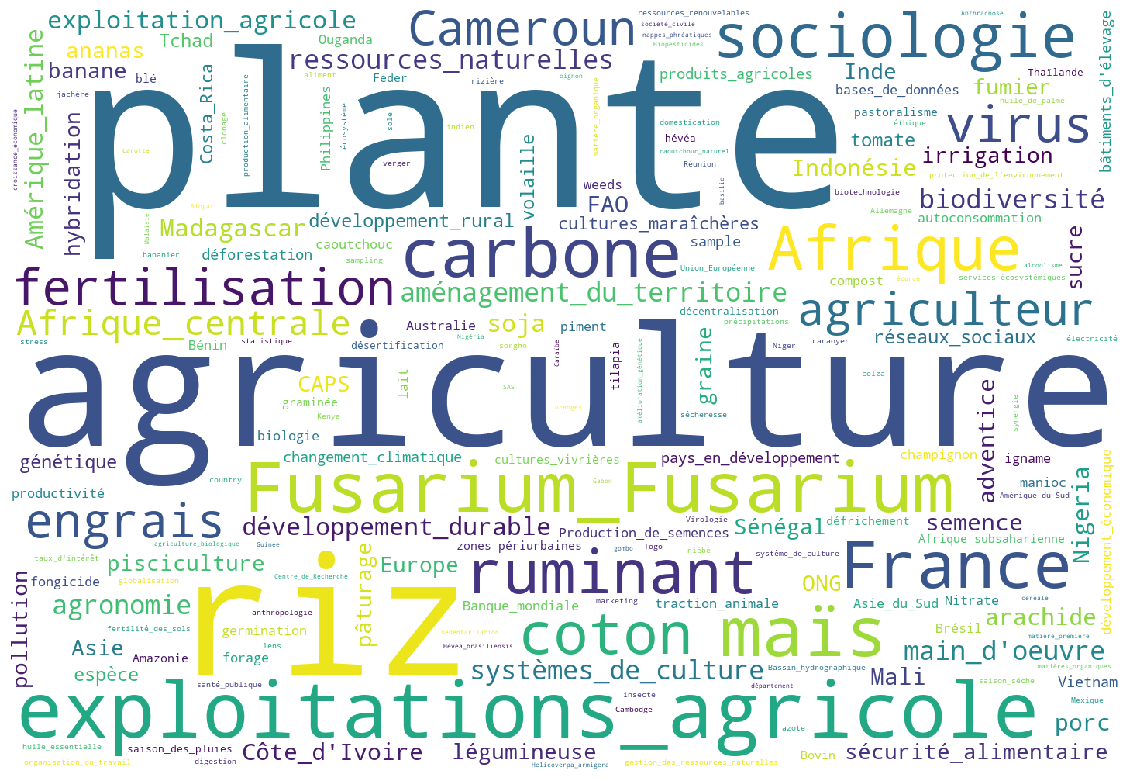

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 15))
img = WordCloud(width=1440, height=990, margin= 10, background_color='white').generate(cagro.text)
ax.imshow(img)
plt.axis('off')
plt.savefig('resources/wordcloudfr.png')

`en_metrics.csv` est généré dans `agrovoc_en.csv` pour pouvoir combiner les deux résultats dans le même violinplot

In [55]:
en_metrics = pd.read_csv('en_metrics.csv')
en_metrics = en_metrics.unstack().reset_index()
en_metrics['level_1'] = 'en'
en_metrics.columns = ['Metric', 'Language', 'Value']

In [56]:
fr_metrics = pd.DataFrame(cagro.memory, columns=['Accuracy', 'Precision', 'Recovery'])
fr_metrics = fr_metrics.unstack().reset_index()
fr_metrics['level_1'] = 'fr'
fr_metrics.columns = ['Metric', 'Language', 'Value']

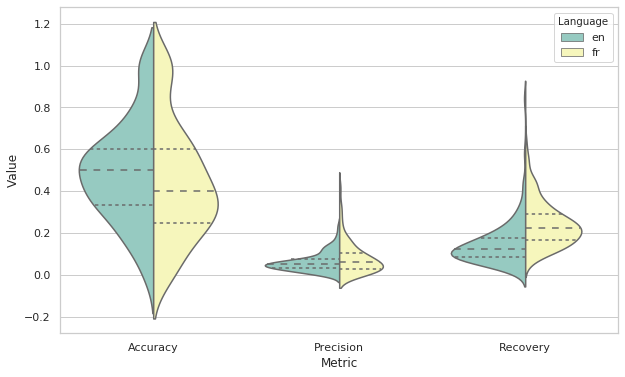

In [58]:
import seaborn as sns
full_data = pd.concat([en_metrics, fr_metrics])
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
ax = sns.violinplot(x='Metric', y='Value', hue='Language', palette="Set3", data=full_data, split=True, inner="quartile")
plt.savefig('resources/violinplot.png')

## Stats sur les résumés

On refait la même chose mais pour les résumés

In [ ]:
abst_agro = GrobidCallback(agrovoc, "Agrovoc")

for i, row in file.iterrows():
    pdf = row['ACCES_TEXTE_INTEGRAL']
    descriptors = row["DESCRIPTEURS"]
    if type(descriptors) == str:
        descriptors = list(map(lambda x: x.strip(), descriptors.split(";")))
    else:
        print('Skipped ', i)
        continue
    metadata = to_agrovoc(descriptors, agrovoc)
    abstract = row['RESUM']
    try:
        text_json = extract_entities(abstract, mode='noxml')
        ent_and_cat = fetch_entities(text_json)    
    except Exception as e:
        print('Failed to process ', i, pdf)
        print(e)
        continue
    print(abst_agro.update(metadata, ent_and_cat))
  
    if abst_agro.examples > 300:
        break
        
print(abst_agro.average_accuracy, abst_agro.average_precision, abst_agro.average_recovery, abst_agro.average_nb_entities)

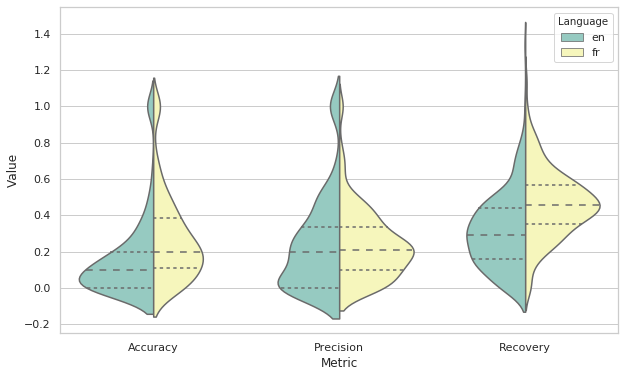

In [16]:
fr_metrics = pd.DataFrame(abst_agro.memory, columns=['Accuracy', 'Precision', 'Recovery'])
fr_metrics = fr_metrics.unstack().reset_index()
fr_metrics['level_1'] = 'fr'
fr_metrics.columns = ['Metric', 'Language', 'Value']

en_metrics = pd.read_csv('en_abstract_metrics.csv')
en_metrics = en_metrics.unstack().reset_index()
en_metrics['level_1'] = 'en'
en_metrics.columns = ['Metric', 'Language', 'Value']

import seaborn as sns
import matplotlib.pyplot as plt
full_data = pd.concat([en_metrics, fr_metrics])
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
ax = sns.violinplot(x='Metric', y='Value', hue='Language', palette="Set3", data=full_data, split=True, inner="quartile")
plt.savefig('resources/abstract_violinplot.png')